In [1]:
import numpy as np
from scipy.optimize import minimize,basinhopping
from matplotlib import pyplot as plt

import pandas as pd

In [2]:
V_carbon_exp = [0.178,
0.164,
0.135,
0.144,
0.146,
0.180]

h_exp = [
5.100,
4.600,
4.870,
4.600,
5.720,
5.570,
]

In [3]:
longs = { "X": 70.0,
          "Y": 70.0,
          "SX": 40.0,
          "SY": 40.0 }

In [4]:
names_layers = ["TFP"+str(i)+"-1" for i in range(1,7)]
names_layers

['TFP1-1', 'TFP2-1', 'TFP3-1', 'TFP4-1', 'TFP5-1', 'TFP6-1']

In [5]:
composition = [
        ["Y", "Y"],
        ["Y", "X"],
        ["Y", "SX"],
        ["Y", "SY"],
        ["Y","SX", "SY"],
        ["Y","X", "SY"]
    ]



In [6]:

def get_df(r_section,remove_A=False):
    r_section = 0.31 # mm

    A_Section = np.pi * r_section**2 # mm^2

    l_layer   = 0.5 # mm
    l_nucleo  = 3.0 # mm
    A_RVE = 10*10 # mm^2



    v_carbon = [2*np.sum([ longs[ic] for ic in comp ] )
                for comp in composition]
    v_carbon = A_Section * np.array(v_carbon)

    n_layer = [len(comp) for comp in composition]
    h_layer = [2*l_layer*n + l_nucleo   for n in n_layer]
    v_tol =   [A_RVE * h for h in h_layer]
    frac_carbon = [v/v_tol for v, v_tol in zip(v_carbon, v_tol)]

    v_tol_h_exp = [A_RVE * h for h in h_exp]
    frac_carbon_h_exp = [v/v_tol for v, v_tol in zip(v_carbon, v_tol_h_exp)]

    df = pd.DataFrame( { "design": names_layers,    
                        "composition": composition,
                        "V carbon [mm3]": v_carbon,
                        "n_layer": n_layer,
                        "h_layer": h_layer,
                        "v_tol"  : v_tol,
                        "Fraction V carbon exp": V_carbon_exp,
                        "Fraction V carbon ": frac_carbon,
                        "Fraction V carbon h exp": frac_carbon_h_exp,
                        })
    
    if remove_A:
        df = df[df.design != "A"]
    return df

radius = 0.31
df = get_df(radius)

df

,design,composition,V carbon [mm3],n_layer,h_layer,v_tol,Fraction V carbon exp,Fraction V carbon,Fraction V carbon h exp
0,TFP1-1,"[Y, Y]",84.533975,2,5.0,500.0,0.178,0.169068,0.165753
1,TFP2-1,"[Y, X]",84.533975,2,5.0,500.0,0.164,0.169068,0.183770
2,TFP3-1,"[Y, SX]",66.419552,2,5.0,500.0,0.135,0.132839,0.136385
3,TFP4-1,"[Y, SY]",66.419552,2,5.0,500.0,0.144,0.132839,0.144390
4,TFP5-1,"[Y, SX, SY]",90.572116,3,6.0,600.0,0.146,0.150954,0.158343
5,TFP6-1,"[Y, X, SY]",108.686539,3,6.0,600.0,0.180,0.181144,0.195128


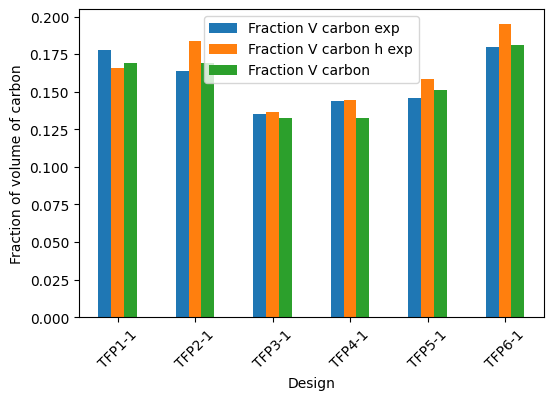

In [7]:
# barplot of the volume of carbon in each layer

fig = plt.figure()
fig.set_size_inches(6, 4)
# compare Fraction V carbon exp	 vs Fraction V carbon  in bar plot 
ax = df.plot(x="design", y=["Fraction V carbon exp", 
                            "Fraction V carbon h exp",
                            "Fraction V carbon "], kind="bar", ax=plt.gca())
ax.set_ylabel("Fraction of volume of carbon")
ax.set_xlabel("Design")
# rotation 
plt.xticks(rotation=45)
plt.show()

In [8]:
def predict_volumen_fraction(r_section,remove_A=False):

    A_Section = np.pi * r_section**2 # mm^2

    l_layer   = 0.5 # mm
    l_nucleo  = 3.0 # mm
    A_RVE = 10*10 # mm^2

    v_carbon = [2*np.sum([ longs[ic] for ic in comp ] )
                for comp in composition]
    v_carbon = A_Section * np.array(v_carbon)

    n_layer = [len(comp) for comp in composition]
    h_layer = [2*l_layer*n + l_nucleo   for n in n_layer]
    v_tol =   [A_RVE * h for h in h_layer]
    frac_carbon = [v/v_tol for v, v_tol in zip(v_carbon, v_tol)]
    frac_carbon = np.array(frac_carbon)

    # remmove first element
    # if remove_A:
    #     frac_carbon = frac_carbon[1:]
    #     V_carbon_exp = V_carbon_exp[1:]

    diff = frac_carbon - V_carbon_exp

    if remove_A:
        diff = diff[1:]
    error = np.sum( (diff)**2 )

    return error




The optimal radius is:  0.3115329363907036


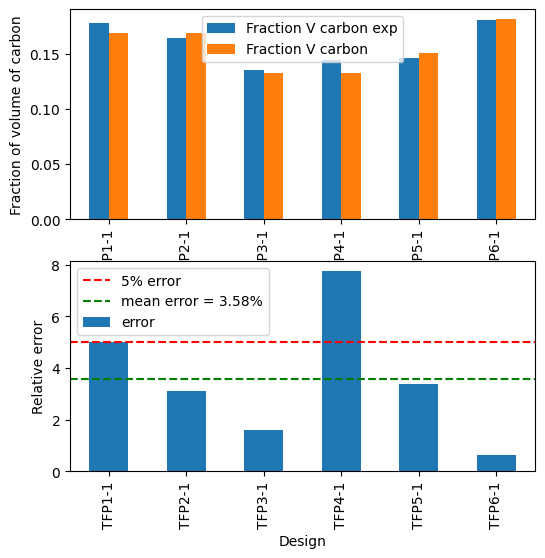

In [9]:


# minimize the error

# res = minimize(predict_volumen_fraction, 0.31, method='Nelder-Mead')
res = basinhopping(predict_volumen_fraction, 0.31, niter=1000)

print("The optimal radius is: ", res.x[0])

radius = res.x[0]
df = get_df(radius)

# barplot of the volume of carbon in each layer

fig = plt.figure()
fig.set_size_inches(6, 6)

plt.subplot(2, 1, 1)
# compare Fraction V carbon exp	 vs Fraction V carbon  in bar plot 
ax = df.plot(x="design", y=["Fraction V carbon exp", "Fraction V carbon "], kind="bar", ax=plt.gca())
ax.set_ylabel("Fraction of volume of carbon")
ax.set_xlabel("Design")

plt.subplot(2, 1, 2)
# relative error
df["error"] = 100*abs(df["Fraction V carbon "] - df["Fraction V carbon exp"])/df["Fraction V carbon exp"]
ax = df.plot(x="design", y="error", kind="bar", ax=plt.gca())
# lines 5 % 
ax.axhline(y=5, color='r', linestyle='--', label="5% error")
# mean line 
ax.axhline(y=df["error"].mean(), color='g', linestyle='--', label="mean error = {:.2f}%".format(df["error"].mean()))
ax.set_ylabel("Relative error")
ax.set_xlabel("Design")

plt.legend()

The optimal radius is:  -0.30994525570140896
The optimal radius is:  -0.30994525570140896


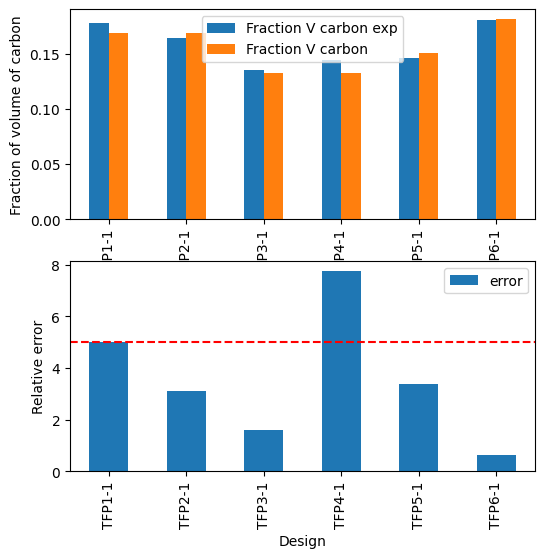

In [10]:


# minimize the error


pvf = lambda r: predict_volumen_fraction(r, remove_A=True)
res = basinhopping(pvf, 0.31)
print("The optimal radius is: ", res.x[0])

radius = res.x[0]
print("The optimal radius is: ", radius)
df = get_df(radius, remove_A=True)

# barplot of the volume of carbon in each layer

fig = plt.figure()
fig.set_size_inches(6, 6)

plt.subplot(2, 1, 1)
# compare Fraction V carbon exp	 vs Fraction V carbon  in bar plot 
ax = df.plot(x="design", y=["Fraction V carbon exp", "Fraction V carbon "], kind="bar", ax=plt.gca())
ax.set_ylabel("Fraction of volume of carbon")
ax.set_xlabel("Design")

plt.subplot(2, 1, 2)
# relative error
df["error"] = 100*abs(df["Fraction V carbon "] - df["Fraction V carbon exp"])/df["Fraction V carbon exp"]
ax = df.plot(x="design", y="error", kind="bar", ax=plt.gca())
# lines 5 % 
ax.axhline(y=5, color='r', linestyle='--')
ax.set_ylabel("Relative error")
ax.set_xlabel("Design")

plt.show()